# 「プチ」勉強会 20230826
* 今回は、実践課題「テストの点数を予測しよう」の探索。
* 比較的簡単な回帰問題だが、単純なだけにもう一歩のEDAの深さを追求し、結果、十分な成果が得られたと思う。
* ChatGPTにもいろいろ聞きながら新しいツールも導入し、これが有益だった。
* 毎回、それなりに発見があるが、今回は最初苦しんだだけに特に感慨深いものがある。

## 今回取り組んでみたこと
1. ザ・重回帰の課題。math score以外のscoreとの相関がとても高く、また、ほとんど一直線の単回帰で近似できる。<br>
つまり、できることは限られているが、その分、深くEDAを進めることができた。
```
   ・解説動画で言及のあった「目的変数との相関係数の順位と回帰係数の順位と一致しない問題」の理由が分かった。
   　相関係数はlunchの方が明確に高いがgenderの回帰係数が大きいのは、それがmath scoreとreading scoreやwriting scoreとの分布の差の説明変数だから。
   ・そもそもreading scoreとwriting scoreは相関係数95%を超えており、ほとんど同じと言ってよいレベル。
   　一方で、math scoreとはいずれも相関係数80%程度に止まってて、これはgenderで色分けして可視化すると一目瞭然。
   　つまり、読み書きの成績に男女差はないか寧ろ女性の方が良いが、数学は男性が明確に優位な分布だということ。
   　改めて考えてみれば、それが世の中のファクトだということに気づく。分布のずれの方向が回帰係数に大きく影響することが改めて確認できた。
   ・今回のケースはとても分かりやすく可視化できたが、解説動画では踏み込んでいない。でもこれがこの課題のポイントのひとつだろう。
```
2. モデルの性能の最適化についてとても示唆のある課題だった。<br>
scikit-learnのleaning_curveメソッドを使用してRMSEの学習曲線を描画するクラスを作成した。
```
   ・解説動画の特徴量エンジニアリングは、reading scoreとwriting scoreの多重共線性に着目してこれらを平均したavg scoreに変換したところまで。
   　あとは全てOne-hotエンコーディングしてそのまま重回帰で予測している。
   ・しかし、この場合のKFoldのクロスバリデーション結果は5.6台であり、解説動画の5.4台、そして提出スコアの5.26はテストデータに適合し過ぎている。
   　実はこれはtrain_test_splitメソッドでtest_size=0.2,randam_state=2とした場合だけの最適化の結果で、汎化性能は低い可能性が高い。
   　今回の課題はtestデータが100個しかないため、testデータに最適化するという裏技が成立してしまうが、それはこの課題の趣旨ではない気がする。
   ・今回、leaning_curveによる学習曲線の可視化により、解説動画の提出スコアにノイズへの過学習が認められた。
   　つまり、ノイズの除去によりスコアが改善する。それがこの課題のもうひとつのポイントに違いない。
```

## テストの点数を予測しよう

In [156]:
# 0-1
# ライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# ここから機械学習用ライブラリ
from sklearn.linear_model import LinearRegression             # 重回帰（今回に限ってこれ以外ない）

# ユーティリティ
from sklearn.metrics import mean_squared_error, r2_score      # RMES, 決定係数
from sklearn.model_selection import train_test_split, KFold   # クロスバリデーション
from metric_plotter import MetricPlotter                      # 自作の学習曲線描画ツール

from sklearn.preprocessing import StandardScaler              # 標準化
from pprint import pprint
from collections import defaultdict
import warnings
warnings.simplefilter('ignore')

# 表示桁数の設定
%precision 3
pd.options.display.precision = 3

sns.set(style='white')
import japanize_matplotlib


In [157]:
# 0-2
# 訓練用データ
df = pd.read_csv('C:\\Users\\yuich\\KC_data\\test_score\\train.csv')
# 提出用データ
df_test = pd.read_csv('C:\\Users\\yuich\\KC_data\\test_score\\test.csv') 

## データ概観

In [158]:
# 1-0
# 訓練データ
display(df.info())
display(df.head())
display(df.describe())
display(df.describe(include='object'))

# 提出用データ
display(df_test.info())
display(df_test.head())
display(df_test.describe())
display(df_test.describe(include='object'))


# 欠損値                     train    test
# test preparation course     603      62
# writing score                 8       2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           900 non-null    int64  
 1   gender                       900 non-null    object 
 2   race/ethnicity               900 non-null    object 
 3   parental level of education  900 non-null    object 
 4   lunch                        900 non-null    object 
 5   test preparation course      297 non-null    object 
 6   reading score                900 non-null    int64  
 7   writing score                892 non-null    float64
 8   math score                   900 non-null    int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 63.4+ KB


None

,ID,gender,race/ethnicity,parental level of education,lunch,test preparation course,reading score,writing score,math score
0,247,male,group D,some high school,standard,NaN,71,61.0,68
1,502,male,group D,associate's degree,standard,NaN,57,59.0,71
2,25,male,group C,high school,free/reduced,NaN,45,42.0,51
3,244,male,group B,some high school,standard,NaN,34,28.0,36
4,652,female,group C,some high school,standard,completed,100,97.0,92


,ID,reading score,writing score,math score
count,900.000,900.000,892.000,900.000
mean,499.838,68.824,67.592,66.347
std,287.677,14.765,15.612,15.222
min,0.000,0.000,0.000,13.000
25%,249.750,59.750,58.000,56.000
50%,501.500,70.000,68.000,67.000
75%,746.250,79.000,79.000,77.000
max,999.000,100.000,100.000,100.000


,gender,race/ethnicity,parental level of education,lunch,test preparation course
count,900,900,900,900,297
unique,2,5,6,2,1
top,male,group C,some college,standard,completed
freq,463,292,192,592,297


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           100 non-null    int64  
 1   gender                       100 non-null    object 
 2   race/ethnicity               100 non-null    object 
 3   parental level of education  100 non-null    object 
 4   lunch                        100 non-null    object 
 5   test preparation course      38 non-null     object 
 6   reading score                100 non-null    int64  
 7   writing score                98 non-null     float64
dtypes: float64(1), int64(2), object(5)
memory usage: 6.4+ KB


None

,ID,gender,race/ethnicity,parental level of education,lunch,test preparation course,reading score,writing score
0,510,male,group E,some college,free/reduced,NaN,79,71.0
1,176,female,group C,bachelor's degree,standard,NaN,56,56.0
2,480,female,group B,some high school,standard,NaN,88,84.0
3,791,female,group C,high school,standard,completed,65,71.0
4,268,female,group B,some college,standard,NaN,58,62.0


,ID,reading score,writing score
count,100.000,100.000,98.000
mean,496.460,69.970,68.663
std,300.384,16.078,16.980
min,8.000,29.000,23.000
25%,240.750,60.000,58.000
50%,482.500,72.500,70.500
75%,771.250,81.250,81.000
max,994.000,98.000,100.000


,gender,race/ethnicity,parental level of education,lunch,test preparation course
count,100,100,100,100,38
unique,2,5,6,2,1
top,male,group C,some college,standard,completed
freq,54,31,30,60,38


## EDA（データ探索）

```Dataset.columns
math score:                  数学の点数
ID:                          受験者番号
gender:                      性別
race/ethnicity:              属性
parental level of education: 親の教育レベル
lunch:                       昼食の状況
test preparation course:     試験対策講座を受けたかどうかの有無
reading score:               リーディングスコア
writing score:               ライティングスコア
```

<Axes: xlabel='math score'>

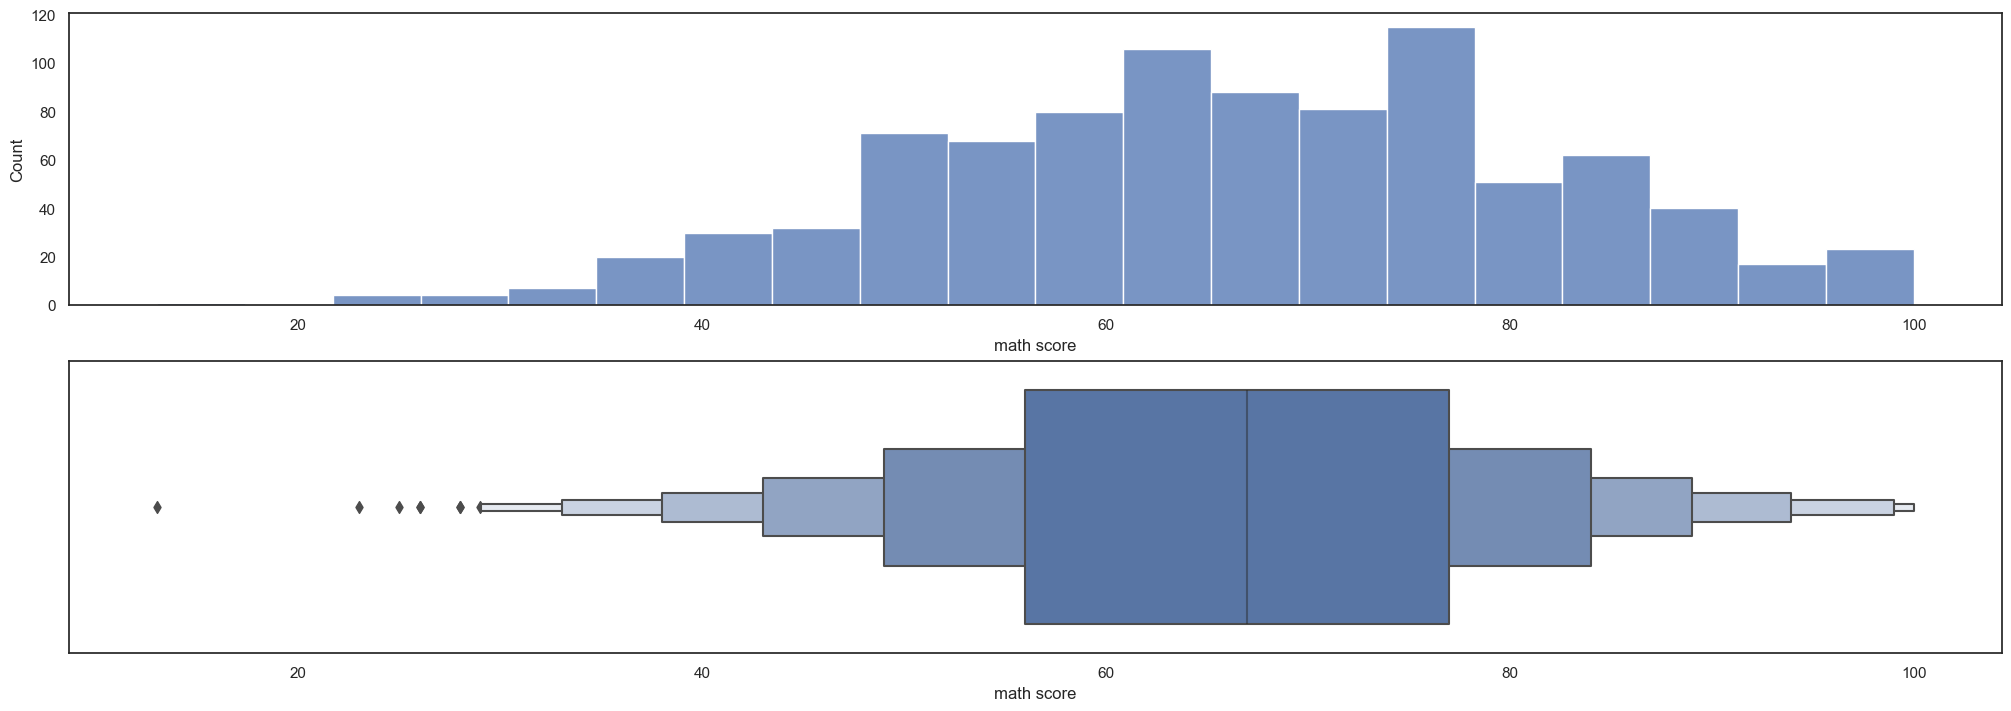

In [159]:
#1-1 math score(目的変数)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 7), layout='constrained')
sns.histplot(df['math score'], ax=ax1)
sns.boxenplot(x=df['math score'], ax=ax2)

# 13～100点、平均66点
# 正規分布っぽい形、下に外れ値がある

,math score,gender
math score,1.000,-0.217
gender,-0.217,1.000


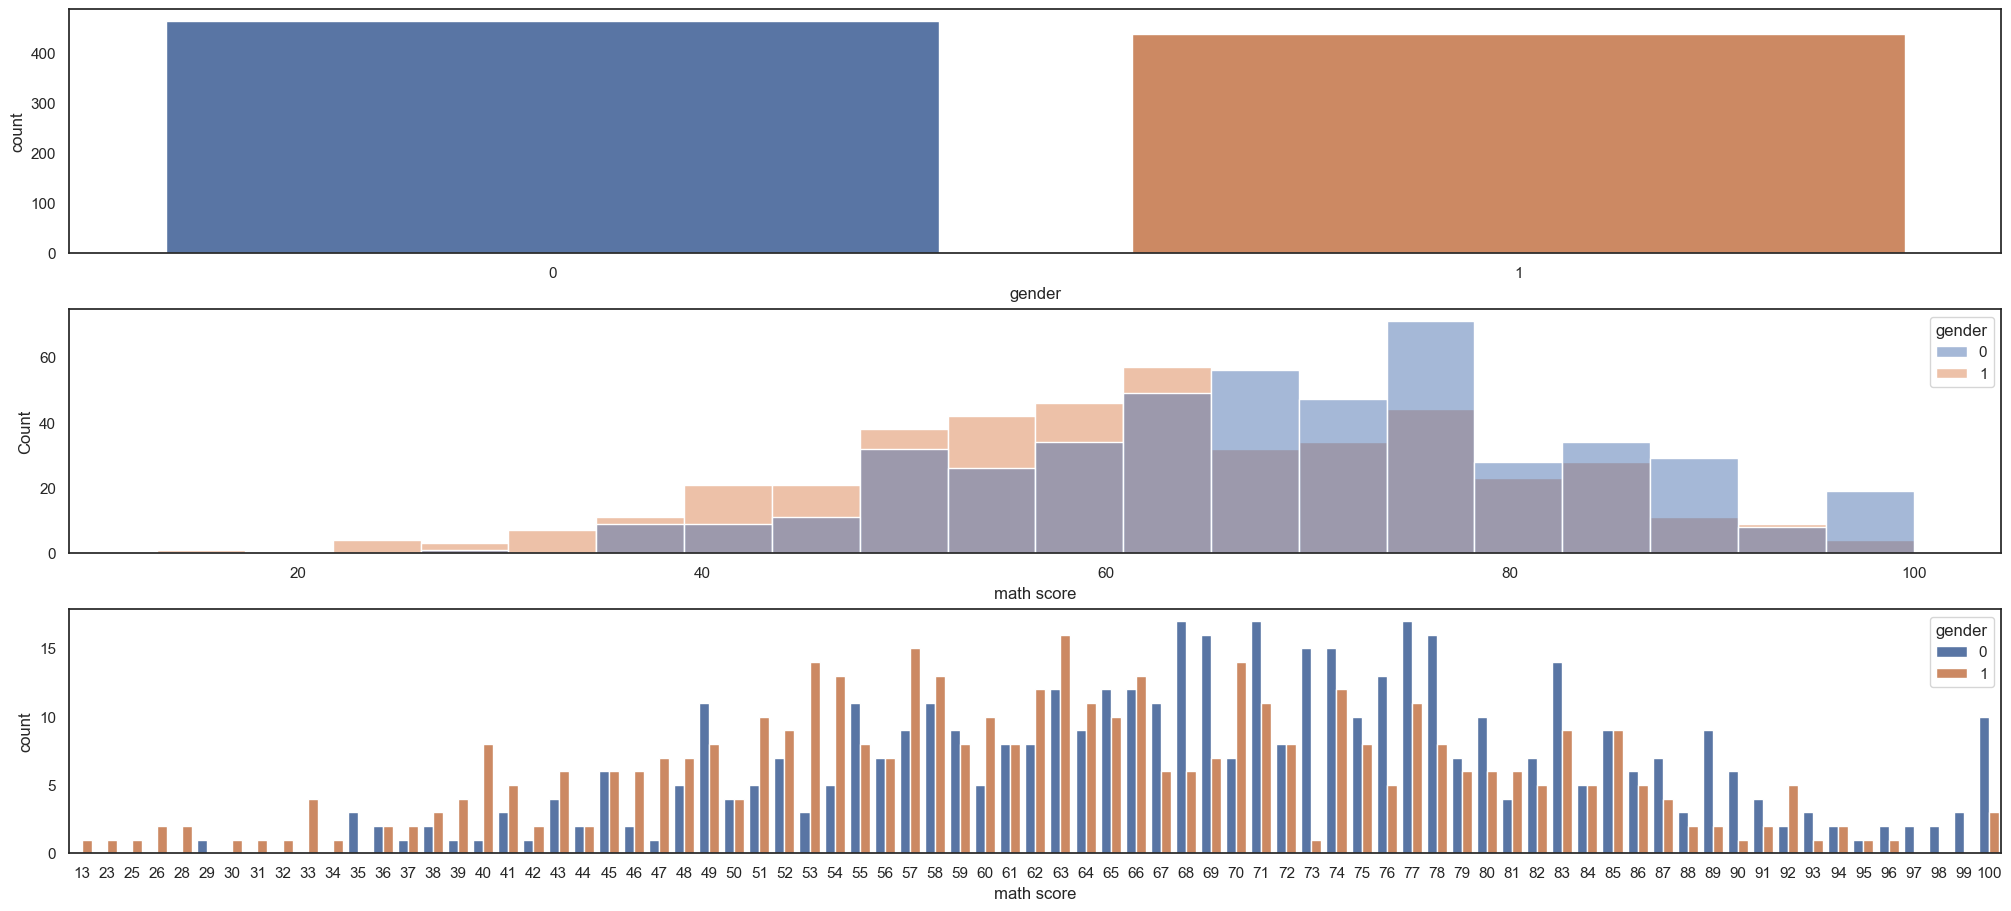

In [190]:
# 1-2 gender

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 9), layout='constrained')
sns.countplot(df, x='gender', ax=ax1)
sns.histplot(df, x='math score', hue='gender', ax=ax2)
sns.countplot(df, x='math score', hue='gender', ax=ax3)

display(df[['math score', 'gender']].corr())

# maleの成績が高め
# 高めというだけで相関係数も特に高くはないが、実はそうではないことが後から判明する

<Axes: xlabel='math score', ylabel='race/ethnicity'>

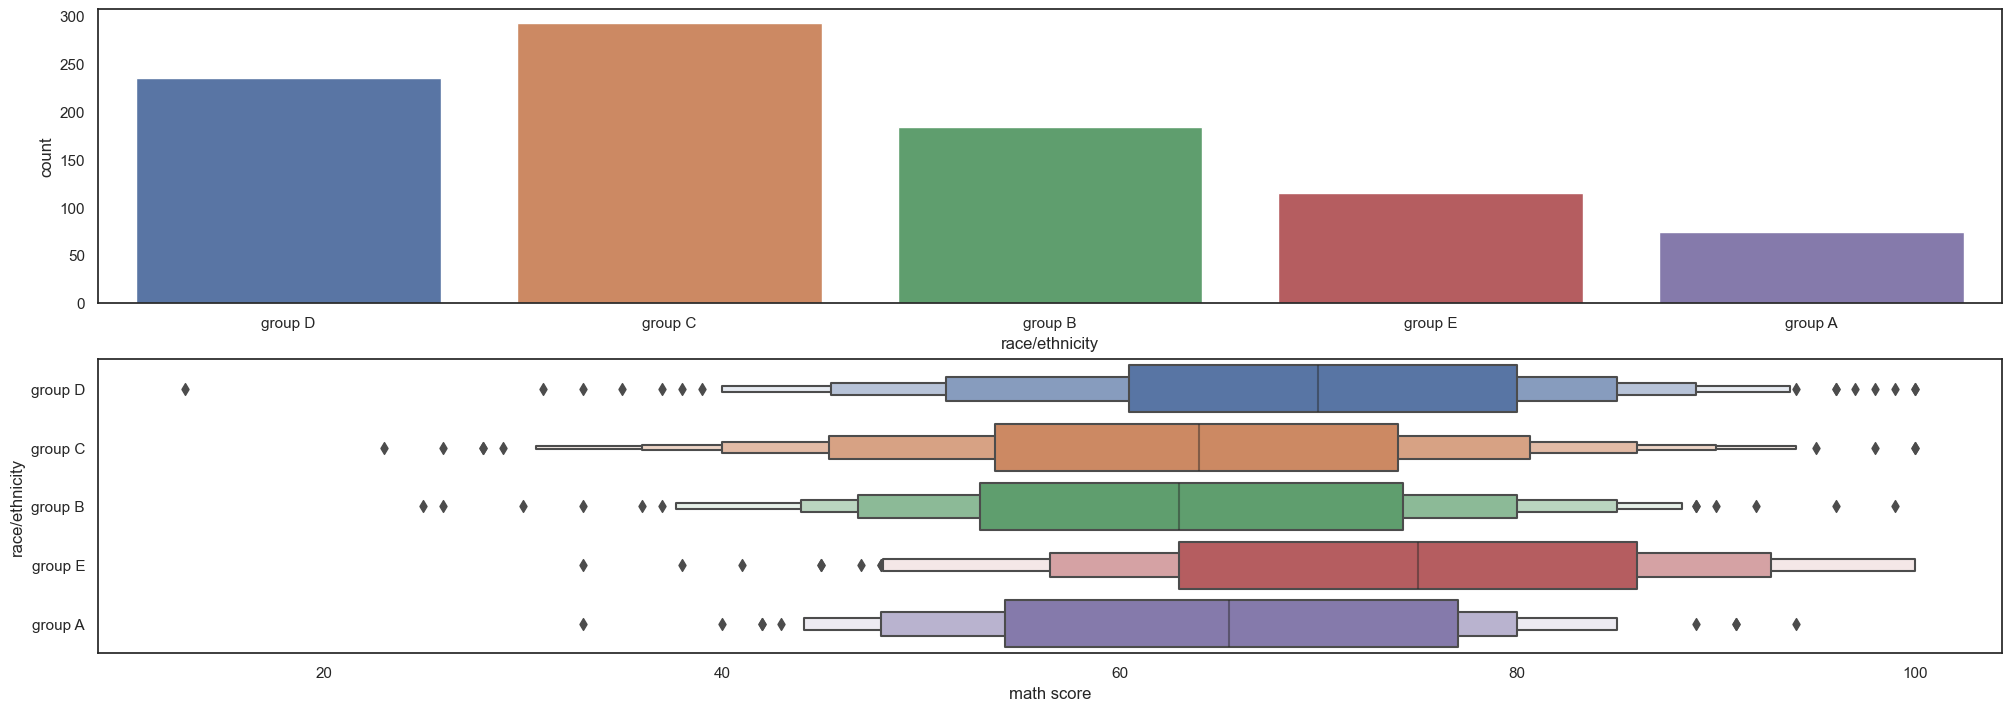

In [161]:
# race/ethnicity

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 7), layout='constrained')
sns.countplot(df, x='race/ethnicity', ax=ax1)
sns.boxenplot(df, y='race/ethnicity', x='math score', ax=ax2)

# Eの平均が高く、Dも比較的高い

# 本件とは直接関係しないが、サイドインフォメーションとして以下の情報を確認した
# 一般に米国でrace/ethnicity5分類といった場合、以下が通例らしい
# どのグループが該当か、そもそも別のカテゴライズかは不明

# White (非ヒスパニック系白人):
#   ヨーロッパ、中東、または北アフリカの出身で、ヒスパニックまたはラティノの背景を持たない人々
# Black or African American (非ヒスパニック系黒人またはアフリカ系アメリカ人):
#   アフリカのサブサハラ地域の出身の人々や、その子孫
# Hispanic or Latino (ヒスパニックまたはラティノ):
#   中南米やスペインの出身、またはその文化的背景を持つ人々
# Asian (アジア人):
#   アジアの広い地域、例えば中国、日本、韓国、インド、ベトナムなどの出身の人々
# Native American or Alaska Native (アメリカ先住民またはアラスカ先住民):
#   アメリカ合衆国本土、アラスカ、ハワイの原住民
# 　このカテゴリーには、ネイティブハワイアンやその他の太平洋諸島の原住民も含まれることがある

<Axes: xlabel='math score', ylabel='parental level of education'>

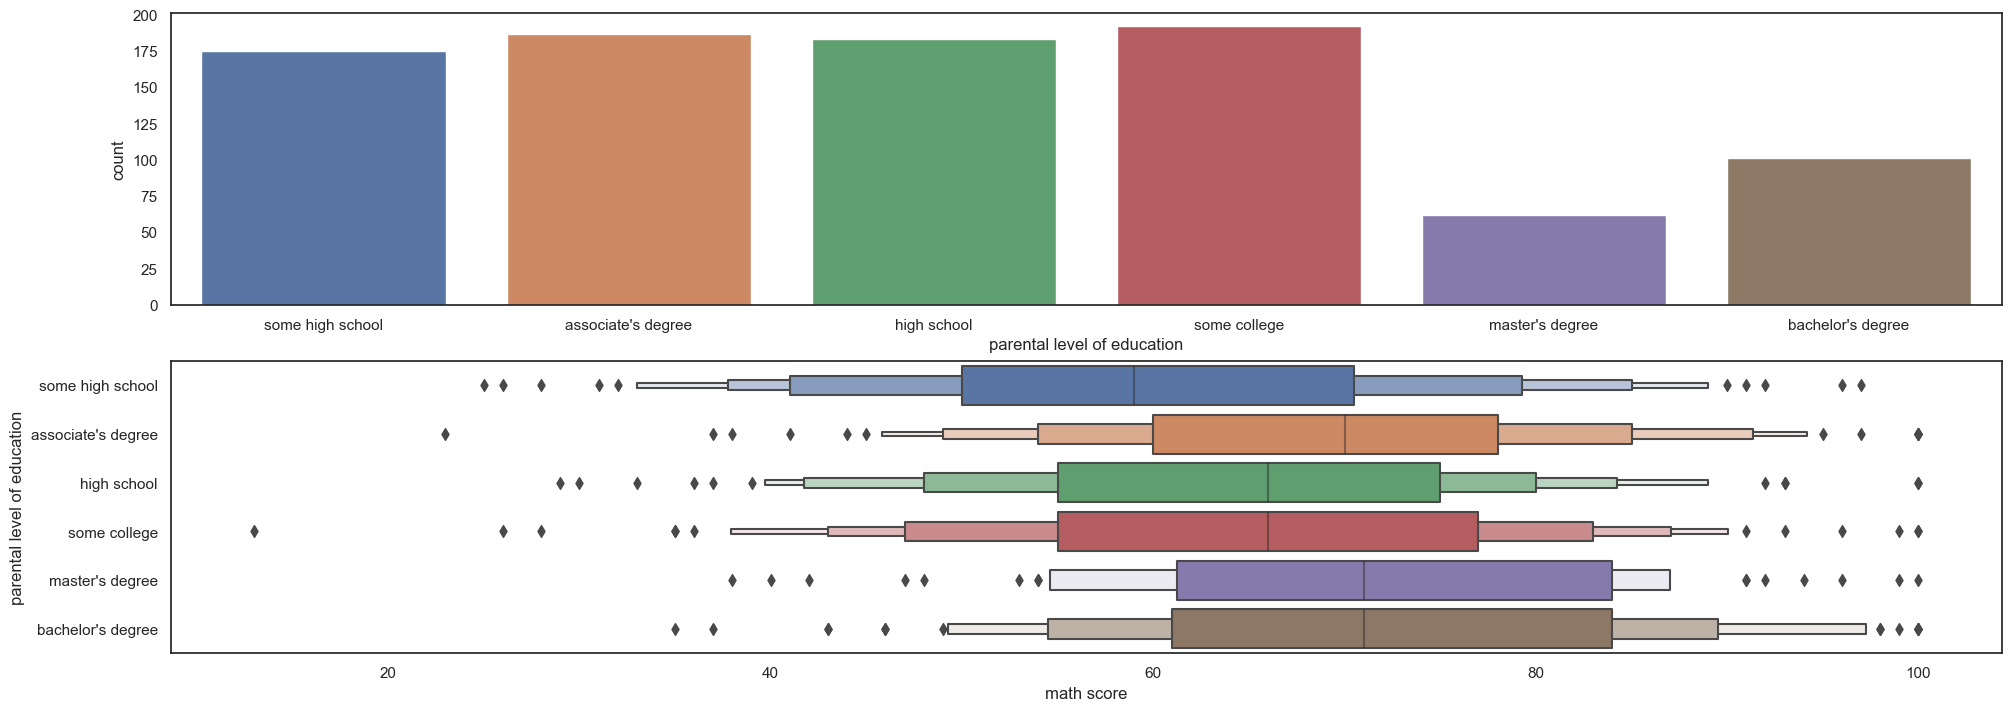

In [162]:
# parental level of education

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 7), layout='constrained')
sns.countplot(df, x='parental level of education', ax=ax1)
sns.boxenplot(df, y='parental level of education', x='math score', ax=ax2)

# Some High School:
#   高校に通っている、もしくは高校に通ったことがあるが、卒業していない状態
# High School:
#   高校を卒業した状態
# 　多くの場合、「高校卒業証書（High School Diploma）」を取得している
# Some College:
#   大学やコミュニティカレッジに入学して何らかのコースを受講したが、学位を取得していない状態
# Associate's Degree:
#   2年制のカレッジ（主にコミュニティカレッジ）を卒業して取得する学位
# Bachelor's Degree:
#   4年制大学を卒業して取得する学位
# Master's Degree:
#   学士号の上位に位置する学位

<Axes: xlabel='math score', ylabel='Count'>

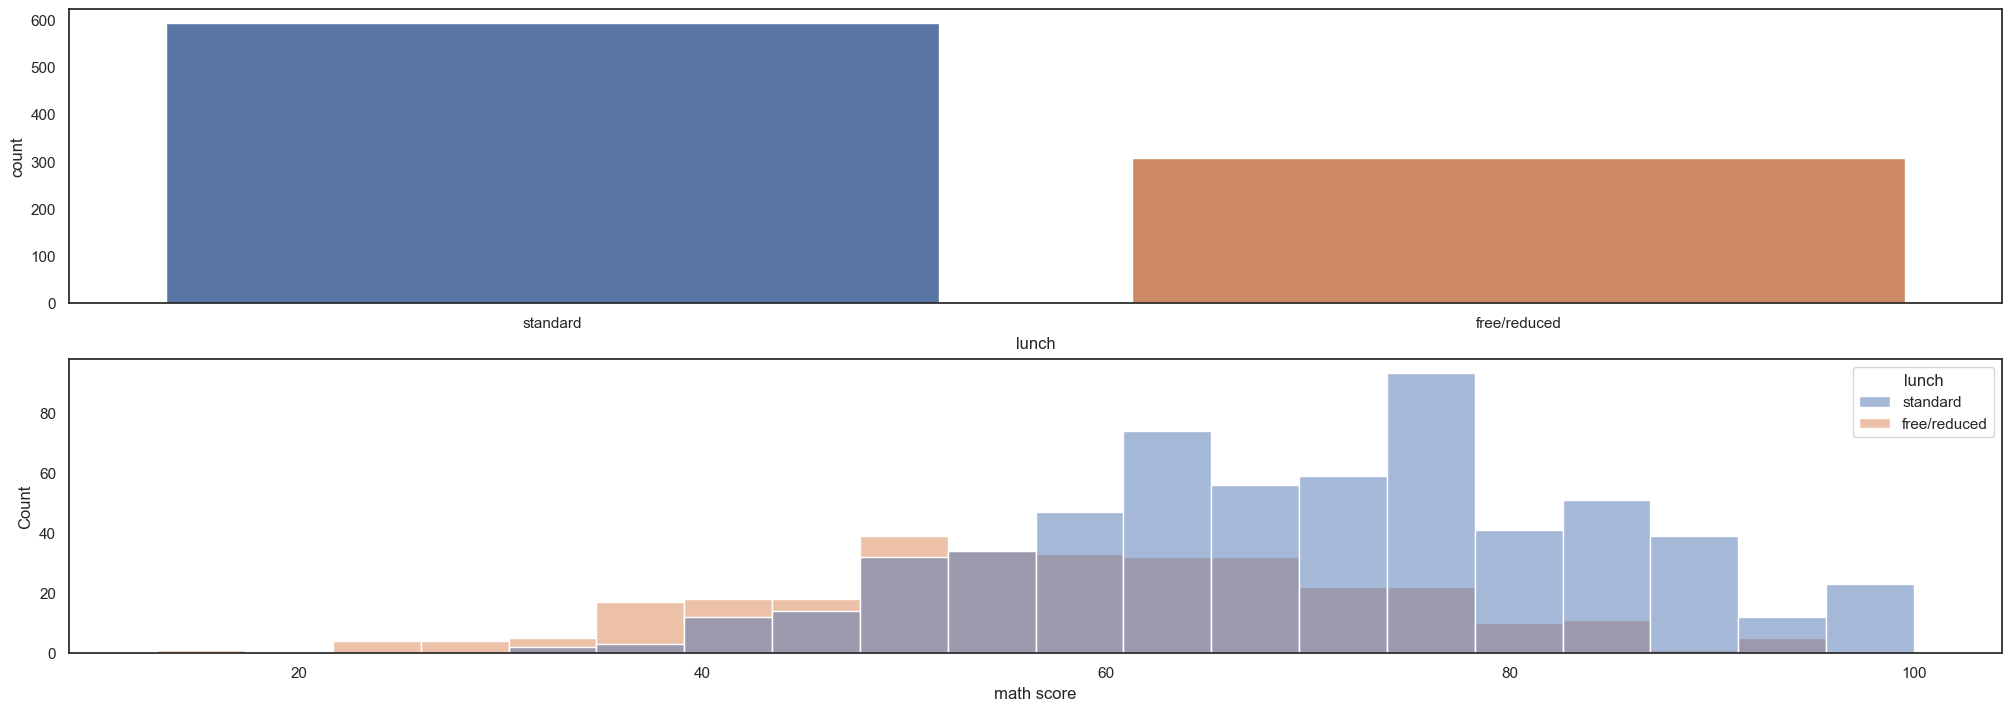

In [163]:
# lunch

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 7), layout='constrained')
sns.countplot(df, x='lunch', ax=ax1)
sns.histplot(df, x='math score', hue='lunch', ax=ax2)

# Standard:
#   このカテゴリに分類される生徒は、学校の給食に対して通常の料金を支払う
# Free/Reduced:
#    無料 (Free) と 割引 (Reduced)がある
#    このプログラムは、経済的に困難な家庭の子供たちが栄養バランスの取れた給食を毎日受け取ることができるようにするためのもの
#    アメリカ合衆国では、このような給食制度が「National School Lunch Program」(NSLP) という連邦プログラムを通じて提供されている

<Axes: xlabel='math score', ylabel='Count'>

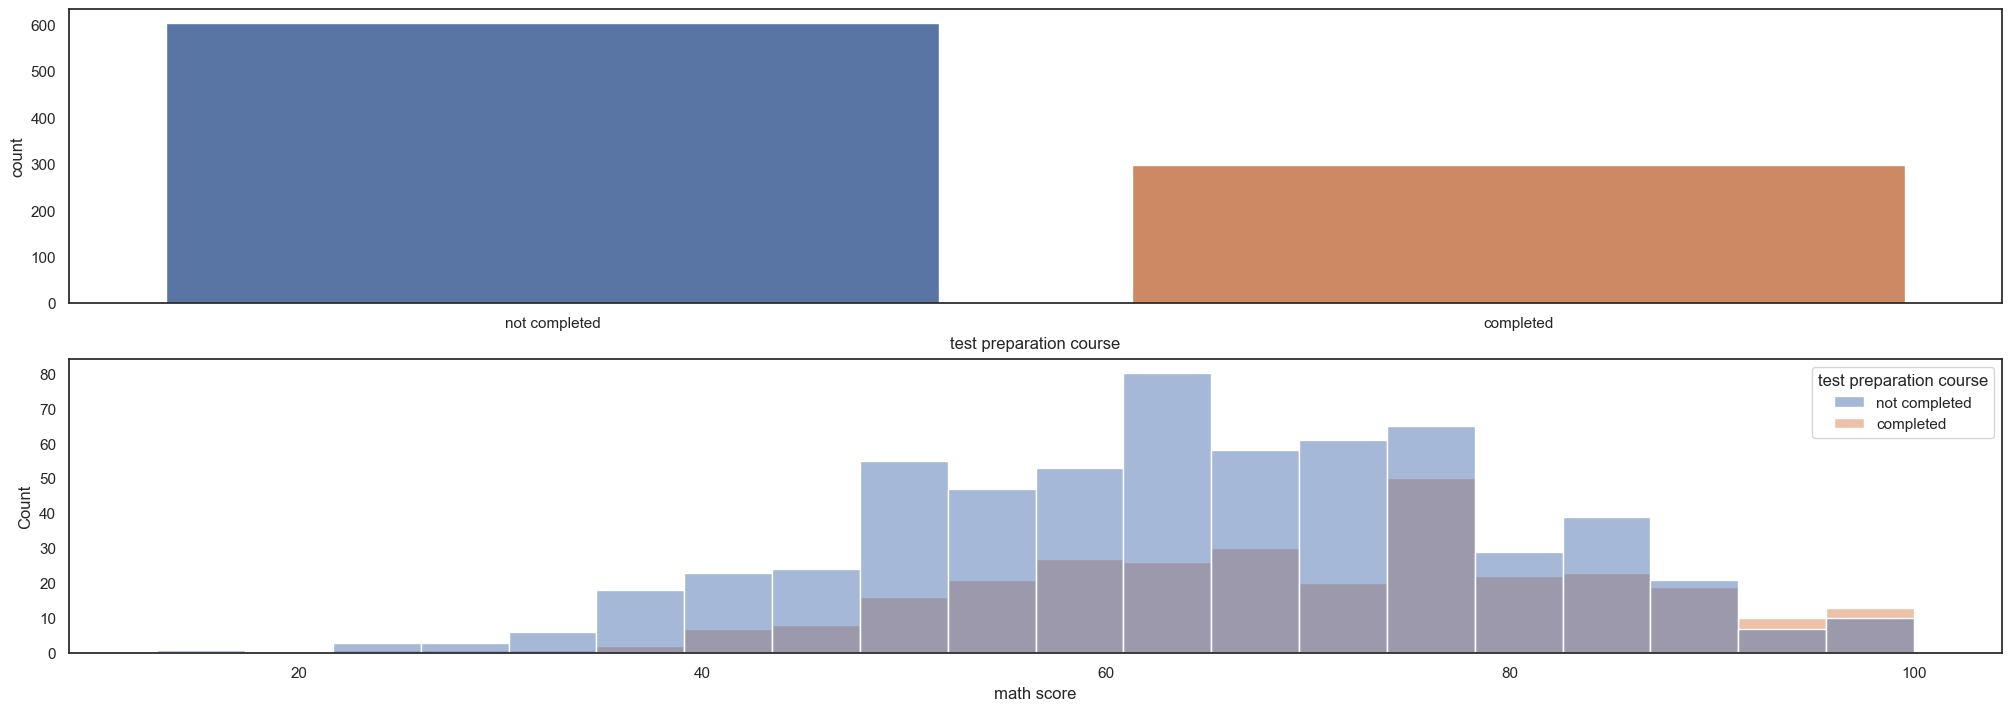

In [164]:
# test preparation course

df.loc[df['test preparation course'].isnull(), 'test preparation course'] = 'not completed'
df_test.loc[df_test['test preparation course'].isnull(), 'test preparation course'] = 'not completed'

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 7), layout='constrained')
sns.countplot(df, x='test preparation course', ax=ax1)
sns.histplot(df, x='math score', hue='test preparation course', ax=ax2)

# 多くが欠損値の形だが、test preparation course "complete"以外なので"not complete"で補完すれば良いと思われる

,ID,gender,race/ethnicity,parental level of education,lunch,test preparation course,reading score,writing score,math score
728,200,female,group D,associate's degree,standard,completed,0,0.0,50


,math score,reading score,writing score
math score,1.000,0.807,0.799
reading score,0.807,1.000,0.955
writing score,0.799,0.955,1.000


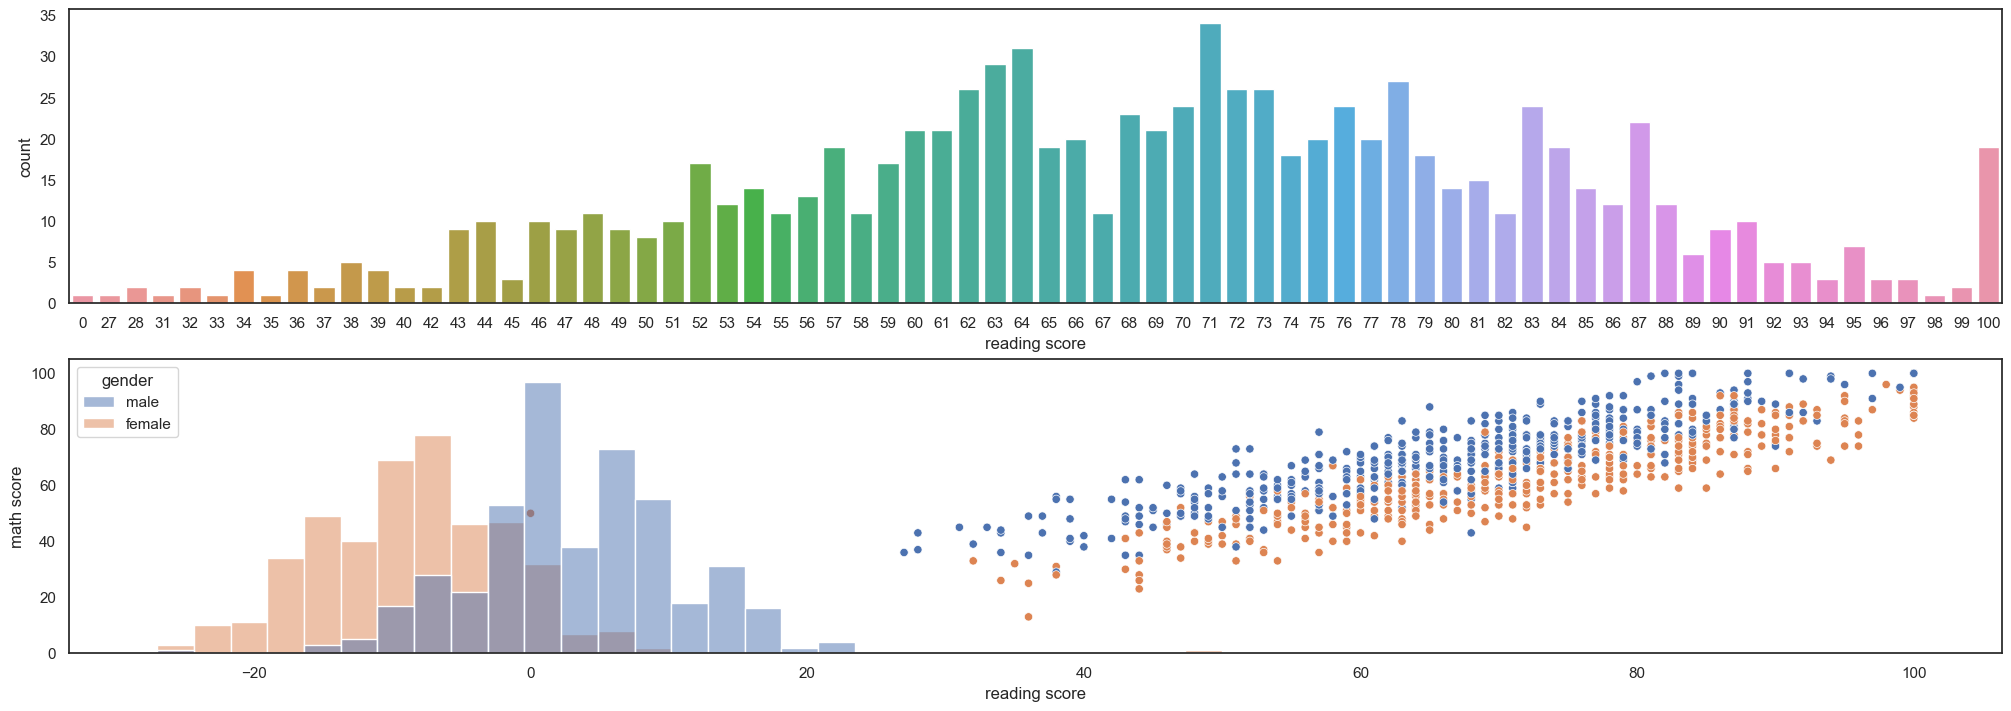

In [165]:
# reading score

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 7), layout='constrained')
sns.countplot(df, x='reading score', ax=ax1)
sns.scatterplot(df, x='reading score', y='math score', hue='gender', ax=ax2)
sns.histplot(df, x=df['math score']-df['reading score'], hue='gender', ax=ax2)

display(df[df['reading score']==0])
display(df[['math score', 'reading score', 'writing score']].corr())

# reading score, writing score 0点が1名だけいる。(df_testには0点はいない)
# 1名のみでmath scoreとの相関もなく異常値なので削除方針

# なお、次のwriting scoreとの相関が95.5%もある一方、目的変数math scoreとの相関は80%程度になっている
# 80%も十分高い相関だが、これは読み書きに共通し、数学とは差がある要素があるということ
# 平均付近が凹んでいるのはそういうこと
# genderで区分するとmaleはmathに、femaleはreadingに偏っており、これがバラつきの主因とわかる
# 解説動画でmath scoreとの直接相関より回帰係数の順位が高いことの言及があったが、中身はこれだろう


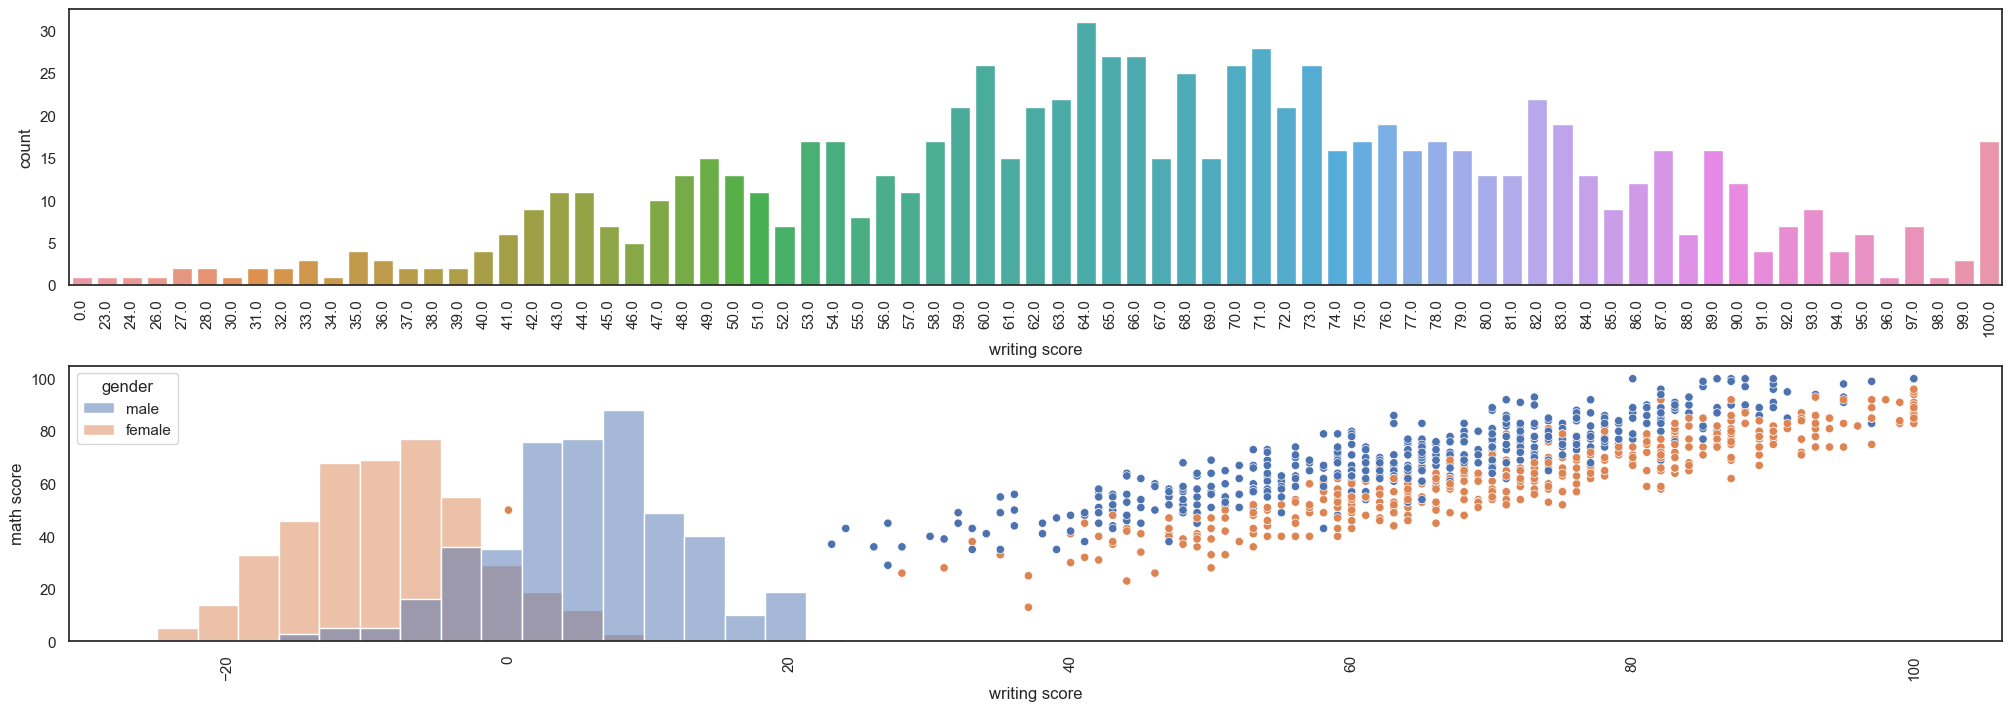

In [166]:
#  writing score

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 7), layout='constrained')
sns.countplot(df, x='writing score', ax=ax1)
sns.scatterplot(df, x='writing score', y='math score', hue='gender', ax=ax2)
sns.histplot(df, x=df['math score'] - df['writing score'], hue='gender', ax=ax2)
ax1.tick_params(axis='x', rotation=90)
ax2.tick_params(axis='x', rotation=90)

# reading scoreと同じ傾向だが、より偏っている印象

In [167]:
# reading score、writing score 0点

display(df[df['reading score']==0])
df = df.loc[df['reading score']!=0]

# 可視化するので先に外れ値処理と次の欠損値補完もここでやってしまう

,ID,gender,race/ethnicity,parental level of education,lunch,test preparation course,reading score,writing score,math score
728,200,female,group D,associate's degree,standard,completed,0,0.0,50


In [168]:
# writing scoreの欠損値補完

display(df[['writing score', 'reading score']].corr())
display(df[df['writing score'].isnull()])

#df.loc[df['writing score'].isnull(), 'writing score'] = df.loc[df['writing score'].isnull(), 'reading score']

for data in [df, df_test]:
    mask = data['writing score'].isnull()
    masked_X = data.loc[~mask, 'reading score'].values.reshape(-1, 1)
    masked_y = data.loc[~mask, 'writing score']
    masked_X_test = data.loc[mask, 'reading score'].values.reshape(-1, 1)
    model = LinearRegression()
    model = model.fit(masked_X, masked_y)
    data.loc[mask, 'writing score'] = np.round(model.predict(masked_X_test))

display(df.loc[[34, 101, 154, 259, 565, 617, 635, 772], :])

mask = df['gender'] == 'male'
display(df.loc[mask, ['math score','reading score','writing score']].corr())
mask = df['gender'] == 'female'
display(df.loc[mask, ['math score','reading score', 'writing score']].corr())


# reading scoreとの相関が非常に高いので、reading scoreで重回帰予測して補完
# gender別のmath scoreとの相関は補完前より気持ち改善

,writing score,reading score
writing score,1.000,0.954
reading score,0.954,1.000


,ID,gender,race/ethnicity,parental level of education,lunch,test preparation course,reading score,writing score,math score
34,810,female,group C,some high school,standard,not completed,51,NaN,49
101,242,male,group D,some high school,standard,not completed,64,NaN,66
154,262,male,group D,some high school,standard,not completed,56,NaN,64
259,507,female,group E,some high school,free/reduced,completed,56,NaN,45
565,49,male,group C,associate's degree,free/reduced,completed,63,NaN,60
617,818,female,group D,some high school,standard,not completed,78,NaN,59
635,318,female,group D,some high school,free/reduced,not completed,86,NaN,64
772,368,female,group C,some high school,free/reduced,not completed,64,NaN,57


,ID,gender,race/ethnicity,parental level of education,lunch,test preparation course,reading score,writing score,math score
34,810,female,group C,some high school,standard,not completed,51,50.0,49
101,242,male,group D,some high school,standard,not completed,64,63.0,66
154,262,male,group D,some high school,standard,not completed,56,55.0,64
259,507,female,group E,some high school,free/reduced,completed,56,55.0,45
565,49,male,group C,associate's degree,free/reduced,completed,63,62.0,60
617,818,female,group D,some high school,standard,not completed,78,77.0,59
635,318,female,group D,some high school,free/reduced,not completed,86,85.0,64
772,368,female,group C,some high school,free/reduced,not completed,64,63.0,57


,math score,reading score,writing score
math score,1.000,0.874,0.892
reading score,0.874,1.000,0.956
writing score,0.892,0.956,1.000


,math score,reading score,writing score
math score,1.000,0.902,0.907
reading score,0.902,1.000,0.952
writing score,0.907,0.952,1.000


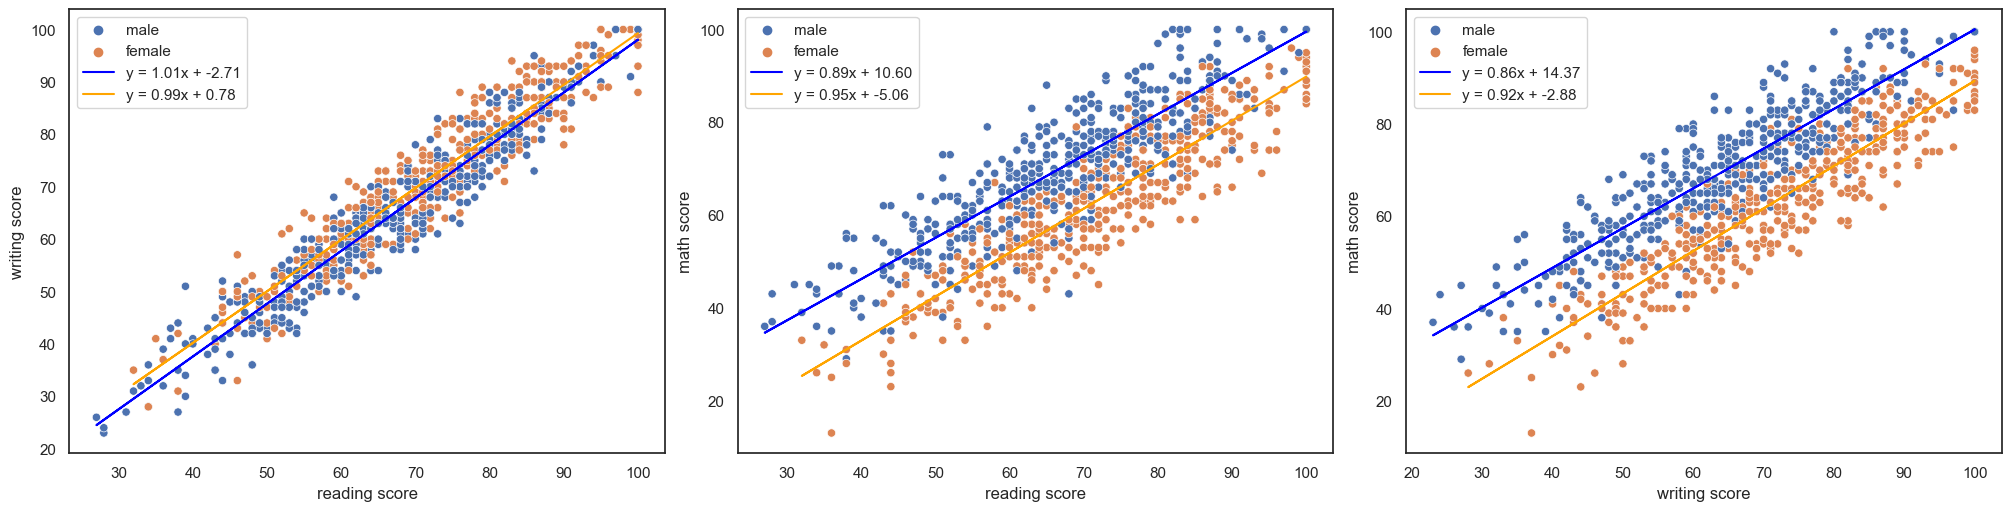

In [169]:
# 可視化

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5), layout='constrained')
sns.scatterplot(df, x='reading score', y='writing score', hue='gender', ax=ax1)
sns.scatterplot(df, x='reading score', y='math score', hue='gender', ax=ax2)
sns.scatterplot(df, x='writing score', y='math score', hue='gender', ax=ax3)

for ax, data in zip([ax1, ax2, ax3], [('reading score', 'writing score'),
                                      ('reading score', 'math score'),
                                      ('writing score', 'math score')]):
    for gen, color in zip(['male', 'female'], ['blue', 'orange']):
        x = df.loc[df['gender'] == gen, data[0]].values
        y = df.loc[df['gender'] == gen, data[1]].values
        a, b = np.polyfit(x, y, 1)
        y_reg = a * x + b
        ax.plot(x, y_reg, color=color, label=f'y = {a:.2f}x + {b:.2f}')
        ax.legend()

# 改めて、reading score, writing score, math scoreの関係を可視化しておく
# 回帰直線を引いてみると良くわかるが、reading scoreとwriting scoreはほぼほぼ同一の範疇
# math scoreとreading score, writing scoreとのブレがほとんどgenderで説明できることが分かる


In [170]:
# 相関係数

mask = df['gender'] == 'male'
display(df.loc[mask, ['math score','reading score','writing score']].corr())
mask = df['gender'] == 'female'
display(df.loc[mask, ['math score','reading score', 'writing score']].corr())

# gender別のwriting scoreがreading scoreよりもmath scoreとの相関が高い

,math score,reading score,writing score
math score,1.000,0.874,0.892
reading score,0.874,1.000,0.956
writing score,0.892,0.956,1.000


,math score,reading score,writing score
math score,1.000,0.902,0.907
reading score,0.902,1.000,0.952
writing score,0.907,0.952,1.000


## 前処理、特徴量エンジニアリング

### 外れ値処理、欠損値補完

In [191]:
# 実施済

### 質的変数のエンコーディング

In [171]:
# One-hotエンコーディング

df['gender'] = df['gender'].apply(lambda x: 1 if x=='female' else 0)
df_test['gender'] = df_test['gender'].apply(lambda x: 1 if x=='female' else 0)
df['lunch'] = df['lunch'].apply(lambda x: 1 if x=='standard' else 0)
df_test['lunch'] = df_test['lunch'].apply(lambda x: 1 if x=='standard' else 0)
df['test preparation course'] = df['test preparation course'].apply(lambda x: 1 if x=='completed' else 0)
df_test['test preparation course'] = df_test['test preparation course'].apply(lambda x: 1 if x=='completed' else 0)


df = pd.get_dummies(data=df, columns=['race/ethnicity', 'parental level of education'],
                    drop_first=True)
df_test = pd.get_dummies(data=df_test, columns=['race/ethnicity', 'parental level of education'],
                         drop_first=True)

# 特段の処理が思いつかなかったので、全てone-hotエンコーディングでばらしてしまう
# 平均点の違いでターゲットエンコーディングする、要素数でカウントエンコーディングする
# あるいは意味的な順序尺度を適用するなども選択肢になるが、目的変数との関係は見出しにくい


### 特徴量生成

In [172]:
# 特徴量 average score

df['average score'] = (df['reading score'] + df['writing score']) / 2
df_test['average score'] = (df_test['reading score'] + df_test['writing score']) / 2

# 多重共線性の問題はスコアよりも回帰係数の信頼性との解説があったが、実際確認するとその通りだと分かる
# 訓練データのRMSE改善だけなら両者を残しておいた方が少し有利だがここは平均を取るアイデアを採用

In [173]:
display(df[['writing score', 'reading score', 'average score', 'math score']].corr())
mask = df['gender'] == 0
display(df.loc[mask, ['writing score', 'reading score', 'average score', 'math score']].corr())
mask = df['gender'] == 1
display(df.loc[mask, ['writing score', 'reading score', 'average score', 'math score']].corr())

# gender別にみてもaverage scoreが最もmath scoreとの相関が高いので、これで代表させることに違和感はない

,writing score,reading score,average score,math score
writing score,1.000,0.954,0.989,0.802
reading score,0.954,1.000,0.988,0.812
average score,0.989,0.988,1.000,0.816
math score,0.802,0.812,0.816,1.000


,writing score,reading score,average score,math score
writing score,1.000,0.956,0.989,0.892
reading score,0.956,1.000,0.988,0.874
average score,0.989,0.988,1.000,0.893
math score,0.892,0.874,0.893,1.000


,writing score,reading score,average score,math score
writing score,1.000,0.952,0.988,0.907
reading score,0.952,1.000,0.987,0.902
average score,0.988,0.987,1.000,0.916
math score,0.907,0.902,0.916,1.000


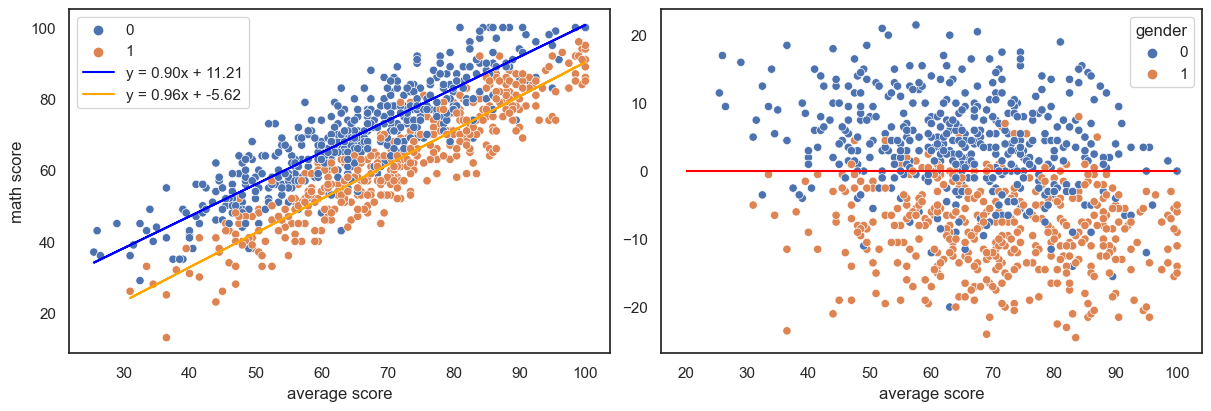

In [174]:
# 可視化

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), layout='constrained')
sns.scatterplot(df, x='average score', y='math score', hue='gender', ax=ax1)
sns.scatterplot(df, x='average score', y=df['math score']- df['average score'], hue='gender', ax=ax2)
ax2.hlines(0, 20, 100, color='red')

for gen, color in zip([0, 1], ['blue', 'orange']):
    x = df.loc[df['gender'] == gen, 'average score'].values
    y = df.loc[df['gender'] == gen, 'math score'].values
    a, b = np.polyfit(x, y, 1)
    y_reg = a * x + b
    ax1.plot(x, y_reg, color=color, label=f'y = {a:.2f}x + {b:.2f}')
    ax1.legend()

# average scoreも可視化しておく

### （少し寄り道）モデルベースの特徴量エンジニアリングにより究極の特徴量を作成する試み
```
　・ノイズを取り込む過学習リスクがあるが、元の特徴量だけでは捉えきれない情報を取り込める場合もある
　・今回は重回帰だからないが、モデルによっては非線形な関係を取り込める可能性もある
　・結果的にテストデータの予測には不適だったが、面白かったので消さずに残した
```

,math score,average score,mixed score
math score,1.000,0.816,0.909
average score,0.816,1.000,0.897
mixed score,0.909,0.897,1.000


6.32554478587447


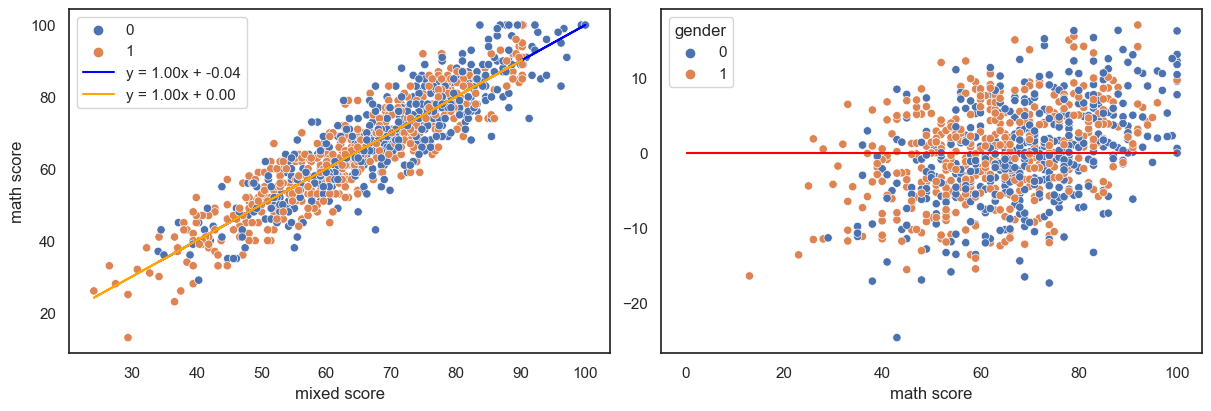

In [175]:
# 特徴量 mixed score(その１)

X = df
features = ['average score']

for i in df['gender'].unique():
    mask = X['gender'] == i
    masked_X = X.loc[mask, features]
    masked_y = X.loc[mask, 'math score']
    model = LinearRegression()
    model = model.fit(masked_X, masked_y)
    pred = model.predict(masked_X)
    df.loc[mask, 'mixed score'] = np.where(pred > 100, 100, pred)

display(df[['math score', 'average score', 'mixed score']].corr())
print(np.sqrt(mean_squared_error(df['math score'], df['mixed score'])))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), layout='constrained')
sns.scatterplot(df, x='mixed score', y='math score', hue='gender', ax=ax1)
sns.scatterplot(df, x='math score', y=df['math score']- df['mixed score'], hue='gender', ax=ax2)
ax2.hlines(0, 0, 100, color='red')

for gen, color in zip([0, 1], ['blue', 'orange']):
    x = df.loc[df['gender'] == gen, 'mixed score'].values
    y = df.loc[df['gender'] == gen, 'math score'].values
    a, b = np.polyfit(x, y, 1)
    y_reg = a * x + b
    ax1.plot(x, y_reg, color=color, label=f'y = {a:.2f}x + {b:.2f}')
    ax1.legend()

# 目的変数を使用して訓練データを特徴量ひとつに集約していく最も効率的な方法を探った
# これはaverage scoreをgenderの要素別に予測したgender mixed score
# これで相関係数は90％越え、RMSEは単独で6.326%
# グラフにも明らかな通り、性別のブレはほぼ解消できる

In [176]:
# 特徴量 mixed score（その２）

model = LinearRegression()
model = model.fit(df[['gender', 'reading score', 'writing score']], df['math score'])
pred = model.predict(df[['gender', 'reading score', 'writing score']])
df.loc[:, 'mixed score'] = np.where(pred > 100, 100, pred)
display(df[['math score', 'average score', 'mixed score']].corr())
print(np.sqrt(mean_squared_error(df['math score'], df['mixed score'])))

# average scoreは使わずに、genderとreading scoreとwriting scoreで予測
# スコア的にはこちらの方が若干良い

,math score,average score,mixed score
math score,1.000,0.816,0.910
average score,0.816,1.000,0.897
mixed score,0.910,0.897,1.000


6.320439224818232


In [177]:
# 特徴量 mixed score(その３)

X = df
X_test = df_test
features = ['reading score', 'writing score']

for i in df['gender'].unique():
    mask = X['gender'] == i
    masked_X = X.loc[mask, features]
    masked_y = X.loc[mask, 'math score']
    model = LinearRegression()
    model = model.fit(masked_X, masked_y)
    pred = model.predict(masked_X)
    df.loc[mask, 'mixed score'] = np.where(pred > 100, 100, pred)
display(df[['math score', 'average score', 'mixed score']].corr())
print(np.sqrt(mean_squared_error(df['math score'], df['mixed score'])))

# reading scoreとwriting scoreを使ってgenderの要素別に予測
# mixed scoreの相関係数、RMSEとも、これがベスト

,math score,average score,mixed score
math score,1.000,0.816,0.910
average score,0.816,1.000,0.896
mixed score,0.910,0.896,1.000


6.295062414059592


In [178]:
# mixed scoreに他の特徴量もmix（その１）

model = LinearRegression()

model = model.fit(df[['lunch', 'test preparation course', 'mixed score']], df['math score'])
pred = model.predict(df[['lunch', 'test preparation course', 'mixed score']])
df.loc[:, 'mixed score'] = np.where(pred > 100, 100, pred)
display(df[['math score', 'average score', 'mixed score']].corr())
print(np.sqrt(mean_squared_error(df['math score'], df['mixed score'])))

# さらにmixed scoreをベースに他の特徴量も組み入れていく
# 相関係数は92.3%、RMSE5.838

,math score,average score,mixed score
math score,1.000,0.816,0.923
average score,0.816,1.000,0.885
mixed score,0.923,0.885,1.000


5.838034888649099


In [179]:
# mixed scoreに他の特徴量もmix（その２）

X = df
features = ['mixed score']

for col in ['lunch', 'test preparation course']:
    for i in df[col].unique():
        mask = X[col] == i
        masked_X = X.loc[mask, features]
        masked_y = X.loc[mask, 'math score']
        model = LinearRegression()
        model = model.fit(masked_X, masked_y)
        pred = model.predict(masked_X)
        df.loc[mask, 'mixed score'] = np.where(pred > 100, 100, pred)
display(df[['math score', 'average score', 'mixed score']].corr())
print(np.sqrt(mean_squared_error(df['math score'], df['mixed score'])))

# 同じことを追加特徴量の要素別に追加で予測
# さらに改善

,math score,average score,mixed score
math score,1.000,0.816,0.923
average score,0.816,1.000,0.885
mixed score,0.923,0.885,1.000


5.836287491986466


In [180]:
# mixed scoreに他の特徴量もmix（その３）

model = LinearRegression()
model = model.fit(df[['race/ethnicity_group B',
                      'race/ethnicity_group C',
                      'race/ethnicity_group D',
                      'race/ethnicity_group E',
                      'mixed score']],
                  df['math score'])

pred = model.predict(df[['race/ethnicity_group B',
                         'race/ethnicity_group C',
                         'race/ethnicity_group D',
                         'race/ethnicity_group E',
                         'mixed score']])

df.loc[:, 'mixed score'] = np.where(pred > 100, 100, pred)
display(df[['math score', 'average score', 'mixed score']].corr())
print(np.sqrt(mean_squared_error(df['math score'], df['mixed score'])))

# 残りの特徴量も全て取り込む
# mixed scoreの相関係数はついに93.1%、RMSE5.544に。

,math score,average score,mixed score
math score,1.000,0.816,0.931
average score,0.816,1.000,0.879
mixed score,0.931,0.879,1.000


5.544326582937225


In [181]:
# mixed scoreに他の特徴量もmix（その４）

X = df
features = ['mixed score']

for col in ['race/ethnicity_group B',
            'race/ethnicity_group C',
            'race/ethnicity_group D',
            'race/ethnicity_group E']:
    for i in df[col].unique():
        mask = X[col] == i
        masked_X = X.loc[mask, features]
        masked_y = X.loc[mask, 'math score']
        model = LinearRegression()
        model = model.fit(masked_X, masked_y)
        pred = model.predict(masked_X)
        df.loc[mask, 'mixed score'] = np.where(pred > 100, 100, pred)

display(df[['math score', 'average score', 'mixed score']].corr())
print(np.sqrt(mean_squared_error(df['math score'], df['mixed score'])))

# 同様に追加特徴量の要素別に追加で予測

,math score,average score,mixed score
math score,1.000,0.816,0.931
average score,0.816,1.000,0.878
mixed score,0.931,0.878,1.000


5.539888429653102


In [182]:
# mixed scoreに他の特徴量もmix（その５）

model = LinearRegression()
model = model.fit(df[["parental level of education_bachelor's degree",
                      'parental level of education_high school',
                      "parental level of education_master's degree",
                      'parental level of education_some college',
                      'parental level of education_some high school',
                      'mixed score']],
                  df['math score'])

pred = model.predict(df[["parental level of education_bachelor's degree",
                         'parental level of education_high school',
                         "parental level of education_master's degree",
                         'parental level of education_some college',
                         'parental level of education_some high school',
                         'mixed score']])

df.loc[:, 'mixed score'] = np.where(pred > 100, 100, pred)
display(df[['math score', 'average score', 'mixed score']].corr())
print(np.sqrt(mean_squared_error(df['math score'], df['mixed score'])))

# 残りも同様に

,math score,average score,mixed score
math score,1.000,0.816,0.932
average score,0.816,1.000,0.877
mixed score,0.932,0.877,1.000


5.529556745028348


,math score,average score,mixed score
math score,1.000,0.816,0.932
average score,0.816,1.000,0.877
mixed score,0.932,0.877,1.000


5.516205900548732


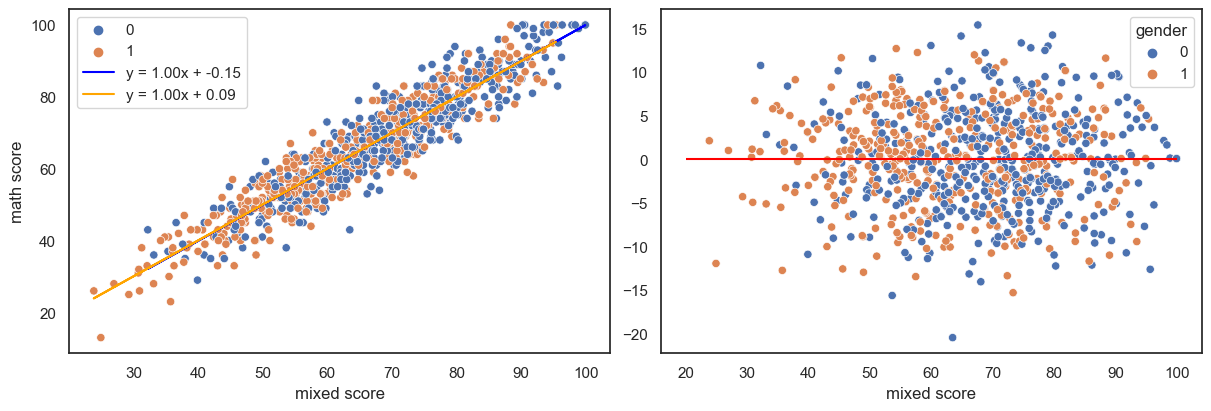

In [183]:
# mixed scoreに他の特徴量もmix（その６）

X = df
features = ['mixed score']

for col in ["parental level of education_bachelor's degree",
            'parental level of education_high school',
            "parental level of education_master's degree",
            'parental level of education_some college',
            'parental level of education_some high school']:
    for i in df[col].unique():
        mask = X[col] == i
        masked_X = X.loc[mask, features]
        masked_y = X.loc[mask, 'math score']
        model = LinearRegression()
        model = model.fit(masked_X, masked_y)
        pred = model.predict(masked_X)
        df.loc[mask, 'mixed score'] = np.where(pred > 100, 100, pred)

display(df[['math score', 'average score', 'mixed score']].corr())
print(np.sqrt(mean_squared_error(df['math score'], df['mixed score'])))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), layout='constrained')
sns.scatterplot(df, x='mixed score', y='math score', hue='gender', ax=ax1)
sns.scatterplot(df, x='mixed score', y=df['math score']- df['mixed score'], hue='gender', ax=ax2)
ax2.hlines(0, 20, 100, color='red')

for gen, color in zip([0, 1], ['blue', 'orange']):
    x = df.loc[df['gender'] == gen, 'mixed score'].values
    y = df.loc[df['gender'] == gen, 'math score'].values
    a, b = np.polyfit(x, y, 1)
    y_reg = a * x + b
    ax1.plot(x, y_reg, color=color, label=f'y = {a:.2f}x + {b:.2f}')
    ax1.legend()
    
# これが最終形。完全にmixed scoreのみとなった。
# math scoreとの相関係数は93.2%　RMSE5.5162
# 特徴量自体の改善がなければ、ぎりぎりやってもこれが限界ということが分かる
# 傾き1で切片もほぼゼロ
# 各特徴量をほぼ完全に取り込んだため一定のノイズも紛れ込んでいるはずだが全ての特徴量を取り込んだ形にはなっている

## モデル生成、予測、評価

In [184]:
X = df[['mixed score']]
y = df['math score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
model_s = LinearRegression()
model_s = model_s.fit(X_train, y_train)
pred = model_s.predict(X_test)
np.sqrt(mean_squared_error(y_test, pred))

# これを解説動画の条件（random_state=2）で計測するとRMSE5.332
# 解説動画は5.4台半ばなので0.1以上改善しているが、だから何という話ではない
# 実際サブミットしたら同じ5.33だった
# 解説動画は5.26だから少し負けているのはやはりノイズだろう

5.332

In [185]:
df.columns

Index(['ID', 'gender', 'lunch', 'test preparation course', 'reading score',
       'writing score', 'math score', 'race/ethnicity_group B',
       'race/ethnicity_group C', 'race/ethnicity_group D',
       'race/ethnicity_group E',
       'parental level of education_bachelor's degree',
       'parental level of education_high school',
       'parental level of education_master's degree',
       'parental level of education_some college',
       'parental level of education_some high school', 'average score',
       'mixed score'],
      dtype='object')

In [186]:

# バリデーションデータの分割
kf = KFold(n_splits=5, shuffle=True, random_state=0)
X = df
y = df['math score']
RMSE = []
r2 = []

features = ['mixed score']

for train_index, val_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_test = y.iloc[train_index], y.iloc[val_index]
    X_train = X_train.loc[:, features]
    X_test = X_test.loc[:, features]

# 標準化
    ss = StandardScaler()
    ss = ss.fit(X_train)
    X_train = ss.transform(X_train)
    X_test = ss.transform(X_test)

# 予測
    LR_model = LinearRegression()
    LR_model = LR_model.fit(X_train, y_train)
    LR_pred = LR_model.predict(X_test)

# RMSE,r2辞書化
    RMSE.append(np.sqrt(mean_squared_error(y_test, LR_pred)))
    r2.append(r2_score(y_test, LR_pred))

print(f'RMSE: {sum(RMSE)/5:.2f}', RMSE)
print(f'r2  : {sum(r2)/5:.2f}', r2)

# KFoldで全体を評価すると平均RMSEは5.52
# これは上述したmixed score自体を予測と見做したRMSEと一致

RMSE: 5.52 [5.681239793656998, 5.165071538622897, 5.632916617539452, 5.499390871971402, 5.639202249088868]
r2  : 0.87 [0.8452684269386009, 0.8934179372711317, 0.8548784400927033, 0.8819438652158077, 0.8558705174146202]


In [187]:
display(pd.DataFrame({'coef': LR_model.coef_}, index=features))

# 集約してしまったので回帰係数はmixed scoreのみに
# もちろん、主な特徴量の回帰係数が欲しい場合は、ばらして計測すれば正しく表示される

,coef
mixed score,14.282


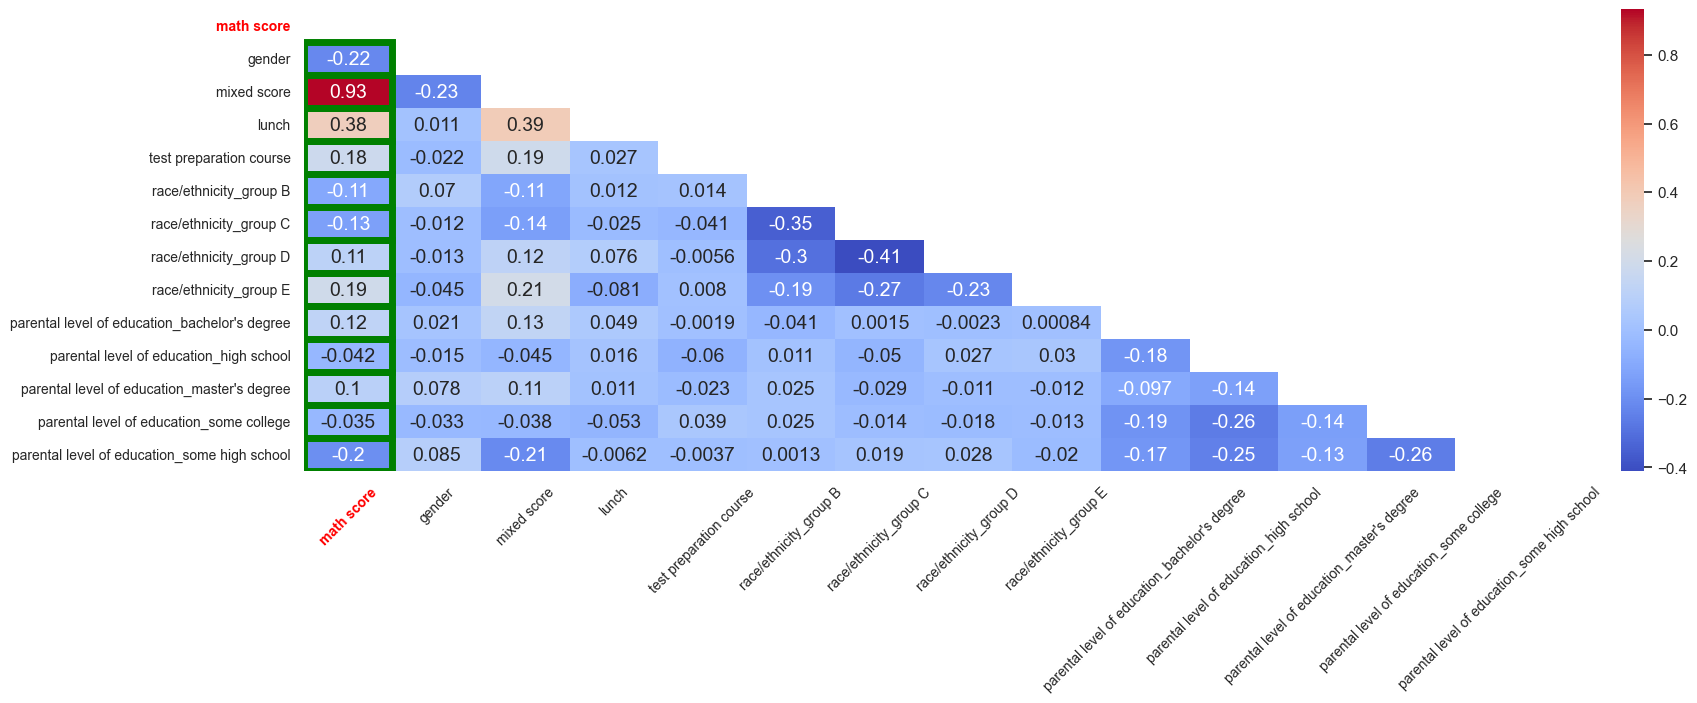

In [188]:
# ヒートマップ,相関係数
feature = ['math score',
       'gender',
       'mixed score',
       'lunch', 'test preparation course',
       'race/ethnicity_group B', 'race/ethnicity_group C',
       'race/ethnicity_group D', 'race/ethnicity_group E',
       "parental level of education_bachelor's degree",
       'parental level of education_high school',
       "parental level of education_master's degree",
       'parental level of education_some college',
       'parental level of education_some high school',
]
corr = df[feature].corr()
fig, ax = plt.subplots(figsize=(20, 6))
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', annot_kws={'size':14})
ax.tick_params(axis='x', labelsize=10, rotation=45)
ax.tick_params(axis='y', labelsize=10)

# 目的変数の枠線の追加
index = list(corr.columns).index('math score')
for i in range(len(corr.columns)):
    if i > index:
        plt.gca().add_patch(plt.Rectangle((index, i), 1, 1,
                                          fill=False, edgecolor='green', lw=5))
    elif i < index:
        plt.gca().add_patch(plt.Rectangle((i, index), 1, 1,
                                          fill=False, edgecolor='green', lw=5))

# 目的変数の強調
for i, label in enumerate(ax.get_xticklabels()):
    if label.get_text() == 'math score':
        label.set_color('red')
        label.set_fontweight('bold')
for i, label in enumerate(ax.get_yticklabels()):
    if label.get_text() == 'math score':
        label.set_color('red')
        label.set_fontweight('bold')
plt.show()

#　他の特徴量も復活させて全体を表示
#  lunchがgenderよりも相関係数が高いことが確認できる

### 学習曲線
```
　さて、ここからが今回のもうひとつの本題。
　今回、学習曲線をscikit-learnのlearning_curveメソッドを用い、ChatGPTくんにも手伝ってもらって可視化するクラスを作成した。
　データフレームで各係数も表示させており、クロスバリデーションを学習曲線を表示させながら確認できるツールに仕上がっている。
　学習曲線を確認することで、ノイズへの過剰適応（過学習）を検知することができる。
　Training scoreとValidation scoreがデータ数の増加により徐々に近づくのはモデルとしてよく機能している現れ。
　一方で、乖離が平行になり縮まらない場合はノイズへの過剰適応が疑われる。
　今回のケースは乖離が大きいわけではないが、特徴量の絞り込みでさらに乖離が縮小し、Validation scoreの改善に資することが確認できる。
```

,0,1,2,3,4,5,6,7,8,9
Training samples,71,143,215,287,359,431,503,575,647,719
Training score,5.128,5.342,5.419,5.490,5.523,5.595,5.603,5.617,5.619,5.611
Validation score,6.267,5.879,5.809,5.821,5.790,5.792,5.787,5.780,5.745,5.725


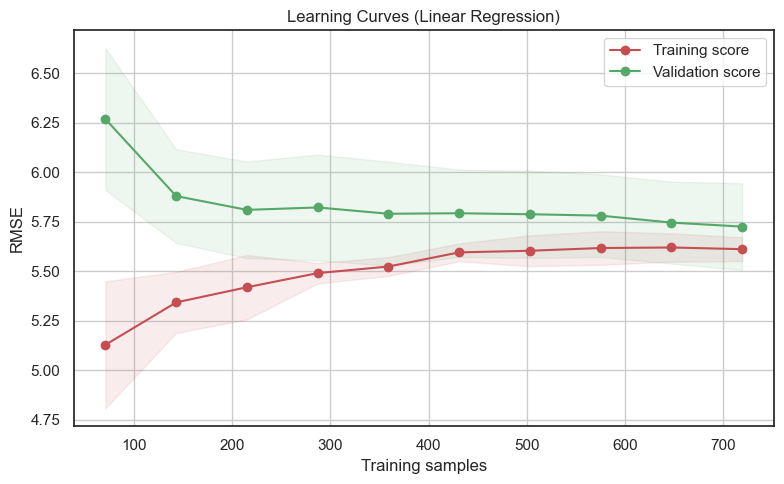

In [189]:

title = "Learning Curves (Linear Regression)"
cv = 5
import lightgbm as lgb
estimator = LinearRegression()

features = [
#    'mixed score'
#    'reading score',
#    'writing score',
    'average score',
    'gender',
    'lunch',
    'test preparation course',
    'race/ethnicity_group B',
    'race/ethnicity_group C',
    'race/ethnicity_group D',
    'race/ethnicity_group E',
    "parental level of education_bachelor's degree",
    'parental level of education_high school',
    "parental level of education_master's degree",
    'parental level of education_some college',
    'parental level of education_some high school'
]
plotter = MetricPlotter(estimator=estimator, title=title, metric='rmse')
_ = plotter.plot_learning_curve(X=df[features], y=df['math score'], cv=cv)

